# 필요한 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
from sklearn.metrics import mean_absolute_error
import pickle
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer,StandardScaler,PowerTransformer,MinMaxScaler
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from itertools import combinations
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
from scipy.stats import spearmanr
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
warnings.filterwarnings(action='ignore')
plt.rc('font',family='Malgun Gothic')
plt.rc('font',size=10)
%matplotlib inline

# 데이터로드

In [2]:
# 빈 데이터 프레임 생성

fm_data_df = pd.DataFrame(columns=['이름','포지션','골','도움','경기당 팀 득점/90',
                                 '경기당 팀 실점/90', 'Cr C/A', 'FA', '반칙 수/90', '기회 창출/90',
                                 '경기당 유효 슈팅/90', '경기당 슈팅/90', 'Int/90', '달린 거리/90분', 
                                 '공중 A/90', '태클 성공률','경기당 패스 시도/90', '경기당 패스 성공/90', 
                                 'K Ps/90', '태클 성공/90', '드리블 성공/90', 
                                 '헤더 성공/90', 'Cr A/90', '평균획득승점/경기'])

# 모든 데이터 프레임 이어붙이기
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2021-2022/2021-2022ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2022-2023/2022-2023ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2023-2024/2023-2024ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)

# 데이터 프레임 컬럼명 변경 및 자료형 변경
fm_data_df.rename(columns={'Cr C/A':'크로스 성공률','FA':'파울 획득','Int/90':'인터셉트/90','공중 A/90':'공중볼시도/90','K Ps/90':'키패스/90','Cr A/90':'크로스 시도/90'},inplace=True)
fm_data_df = fm_data_df.astype({'골':np.int64,'도움':np.int64,'파울 획득':np.int64,'태클 성공률':np.int64})

# 공격수만 추출
midfielder_df = fm_data_df[fm_data_df['포지션']=='미드필더']
midfielder_df = midfielder_df.reset_index(drop=True)

# 데이터 EDA

## 모델 생성에 사용할 독립변수, 종속변수 선별

In [3]:
num_col = [midfielder_df.columns[i] for i,x in enumerate(midfielder_df.dtypes) if x == 'int64' or x == 'float64']
independent_value = set(num_col) - set(['평균획득승점/경기','출장시간','승','무','패','경기당 팀 득점/90','경기당 팀 실점/90'])
dependent_value = '평균획득승점/경기'

## 결측치 확인

In [4]:
midfielder_df.isna().sum()

이름              0
포지션             0
골               0
도움              0
경기당 팀 득점/90     0
경기당 팀 실점/90     0
크로스 성공률         0
파울 획득           0
반칙 수/90         0
기회 창출/90        0
경기당 유효 슈팅/90    0
경기당 슈팅/90       0
인터셉트/90         0
달린 거리/90분       0
공중볼시도/90        0
태클 성공률          0
경기당 패스 시도/90    0
경기당 패스 성공/90    0
키패스/90          0
태클 성공/90        0
드리블 성공/90       0
헤더 성공/90        0
크로스 시도/90       0
평균획득승점/경기       0
시즌              0
dtype: int64

# LGBM Regressor 모델 생성

In [5]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV,train_test_split,StratifiedKFold

x_train,x_test,y_train,y_test = train_test_split(fm_data_df.loc[:,independent_value],fm_data_df.loc[:,dependent_value],test_size=0.2,random_state=123)

In [6]:
midfielder_lgbm = LGBMRegressor()

params = {
    'num_leaves': [10],
    'learning_rate': [0.2],
    'max_depth': [-1],
    'n_estimators': [153],
    'objective' : ["regression"],
    'random_state' :[123],
    'reg_alpha' : [1.2],
    'reg_lambda' : [1.15,],
    'subsample': [0.7],
    'extra_trees' : [True]
}


grid = GridSearchCV(midfielder_lgbm, params, scoring='neg_mean_absolute_error', cv=10,refit=True)

grid.fit(midfielder_df.loc[:,independent_value],
         midfielder_df.loc[:,dependent_value])

print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

-0.3129856460775836
LGBMRegressor(extra_trees=True, learning_rate=0.2, n_estimators=153,
              num_leaves=10, objective='regression', random_state=123,
              reg_alpha=1.2, reg_lambda=1.15, subsample=0.7)
{'extra_trees': True, 'learning_rate': 0.2, 'max_depth': -1, 'n_estimators': 153, 'num_leaves': 10, 'objective': 'regression', 'random_state': 123, 'reg_alpha': 1.2, 'reg_lambda': 1.15, 'subsample': 0.7}


In [7]:
midfielder_lgbm = LGBMRegressor(
                num_leaves=10,
                learning_rate=0.2,
                max_depth=-1,
                n_estimators=153,
                objective='regression',
                random_state=123,
                reg_alpha=1.2,
                reg_lambda=1.15,
                subsample=0.7,
                extra_trees=True
                )

In [8]:
midfielder_lgbm.fit(x_train,y_train)

LGBMRegressor(extra_trees=True, learning_rate=0.2, n_estimators=153,
              num_leaves=10, objective='regression', random_state=123,
              reg_alpha=1.2, reg_lambda=1.15, subsample=0.7)

In [9]:
y_pred = midfielder_lgbm.predict(x_test)
mean_absolute_error(y_test,y_pred)

0.3027124070678978

# 모델검정

In [10]:
midfielder_df['predict'] = grid.predict(midfielder_df.loc[:,independent_value])

In [11]:
residual = midfielder_df['평균획득승점/경기'] - midfielder_df['predict']

## 선형성 검정

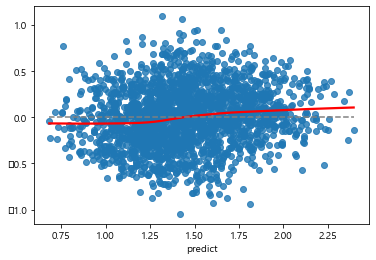

In [12]:
sns.regplot(midfielder_df['predict'], residual, lowess=True, line_kws={'color': 'red'})
plt.plot([midfielder_df['predict'].values.min(), midfielder_df['predict'].values.max()], [0, 0], '--', color='grey')

## 잔차의 정규성 검정

In [13]:
# 정규성 만족
stats.shapiro(residual)

ShapiroResult(statistic=0.9992498755455017, pvalue=0.5763483047485352)

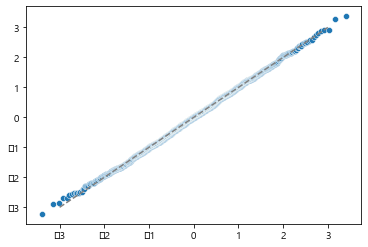

In [14]:
sr = stats.zscore(residual)
(x, y), _ = stats.probplot(sr)
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color='grey')

## 잔차의 등분산성 검정

<AxesSubplot:xlabel='predict'>

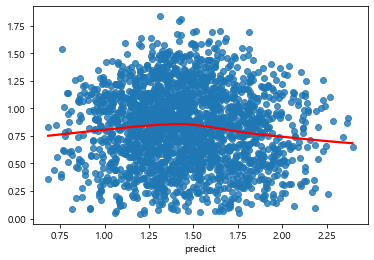

In [15]:
sns.regplot(midfielder_df['predict'], np.sqrt(np.abs(sr)), lowess=True, line_kws={'color': 'red'})

In [16]:
# 등분산성 불만족
stats.levene(midfielder_df['평균획득승점/경기'],midfielder_df['predict'])

LeveneResult(statistic=450.2962599330782, pvalue=5.346770850199801e-95)

In [17]:
import joblib

#joblib.dump(midfielder_lgbm, './models/midfielder_lgbm.pkl')

## 변수 중요도 도출

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

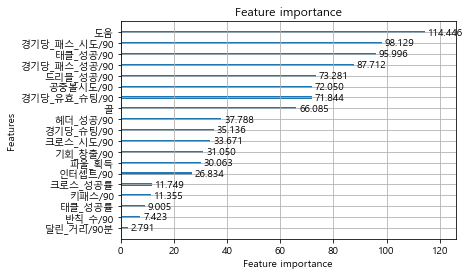

In [19]:
from lightgbm import plot_importance

plot_importance(midfielder_lgbm,max_num_features=len(independent_value),importance_type='gain')

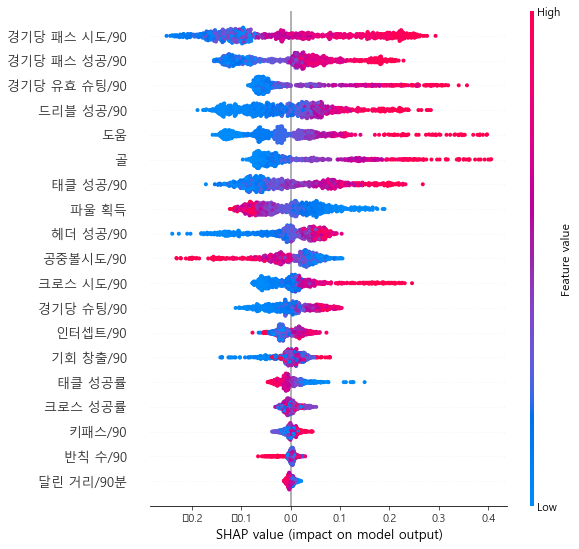

In [20]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(midfielder_lgbm)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test)